# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Sensitivity analysis often focuses on the **final values** of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using the *statsmodel library and an **appropriate sampling** design*, **fit a linear regression model** for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment
  

* Perform an appropriate number of experiments with the Sobol sampling functionality included in the Workbench, then analyze the results with SALib for the same three indicators. How can we interpret the first-order and total indices? Does your chosen sample size give a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 


* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices?

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import itertools

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, Constant, perform_experiments, ema_logging)

from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.connectors.pysd_connector import PysdModel

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import CLASSIFICATION, REGRESSION
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

def PredPrey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, final_time=365, reps=1):

    #Initial values
    predators, prey, sim_time = [np.zeros((reps, int(final_time/dt)+1)) for _ in range(3)]
    
    for r in range(reps):
        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

        #Calculate the time series
        for t in range(0, sim_time.shape[1]-1):

            dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
            dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

            prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
            predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
            sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

In [14]:
model = Model(name="PreyPred", function=PredPrey)

In [15]:
uncertainties = [
    RealParameter('prey_birth_rate',0.015,0.035),
    RealParameter('predation_rate',0.0005,0.003),
    RealParameter('predator_efficiency',0.001,0.004),
    RealParameter('predator_loss_rate',0.04,0.08),
]

outcomes = [
    TimeSeriesOutcome("TIME"),
    TimeSeriesOutcome("predators",),
    TimeSeriesOutcome("prey"),
]

constants = [
    Constant("final_time", 365),
    Constant("dt", 0.25)
]

In [16]:
model.uncertainties = uncertainties
model.outcomes = outcomes
model.constants = constants

In [19]:
n_scenarios = 1000
ema_logging.log_to_stderr(ema_logging.INFO)
results = perform_experiments(models=model, scenarios=n_scenarios)

[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished


In [107]:
def result_df(result):
    df = pd.DataFrame()
    for i, key in enumerate(result[1].keys()):
        df[key] = result[1][key].flatten()
    n_exp = result[1][key].shape[0]
    t_steps = result[1][key].shape[-1]

    df["experiment"] = np.repeat(range(n_exp), t_steps)
    return df

def result_input(results):
    df_input = pd.DataFrame(index=list(results[0].dtype.names)[:5])
    for i in range(len(results[0])):
        df_input[i] = list(results[0][i])[:5]
    return df_input.T

df = result_df(results)
df_input = result_input(results)

In [108]:
df_input["final_prey"] = np.nan
final_prey = df[df["TIME"] == 365]["prey"].values
df_input["final_prey"] = final_prey

df_input["mu_prey"] = np.nan
df_input["std_prey"] = np.nan
for i in range(n_scenarios):
    mu_prey = df[df["experiment"] == i]["prey"].mean()
    df_input["mu_prey"].loc[i] = mu_prey
    
    std_prey = df[df["experiment"] == i]["prey"].std()
    df_input["std_prey"].loc[i] = std_prey

df_input.drop("scenario_id", axis = 1, inplace = True)

In [110]:
df_outcome = df_input.iloc[:, 4:]
df_input = df_input.iloc[:, :4]

In [111]:
df_input.head()

,predation_rate,predator_efficiency,predator_loss_rate,prey_birth_rate
0,0.001222,0.002808,0.049610,0.034776
1,0.000753,0.001640,0.055636,0.015153
2,0.002254,0.003949,0.065178,0.021044
3,0.002146,0.002176,0.045831,0.027754
4,0.002998,0.003901,0.040565,0.025717


In [112]:
df_outcome.head()

,final_prey,mu_prey,std_prey
0,54.483917,18.199209,16.451250
1,27.377760,32.564858,10.129865
2,7.115214,13.483825,15.038945
3,34.055510,18.522236,14.257445
4,0.306692,10.458281,15.284684


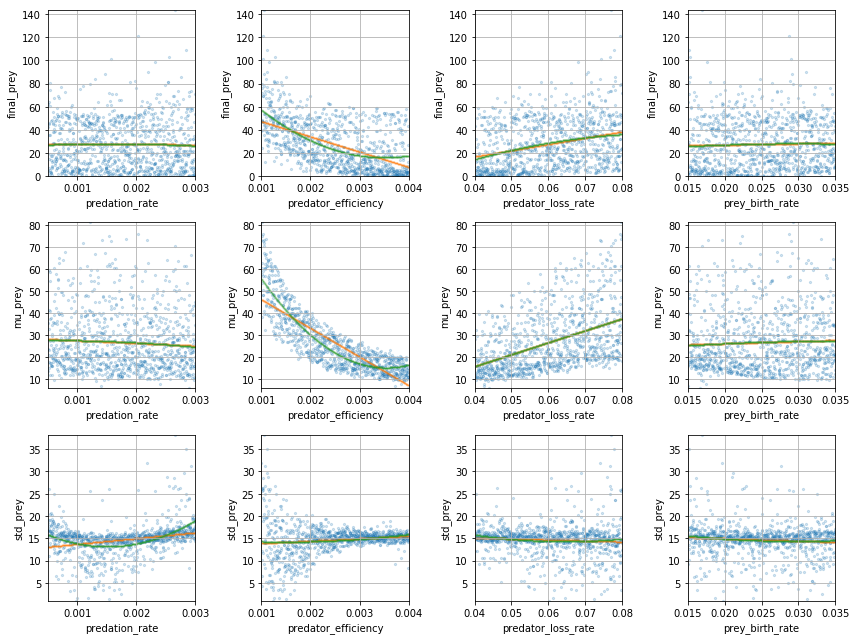

In [167]:
nrows = df_outcome.shape[1]
ncols = df_input.shape[1]

fig, axes = plt.subplots(nrows=nrows,ncols=ncols,
                         figsize=(ncols*3, nrows*3))
locs = list(itertools.product(range(nrows), range(ncols)))
i = 0
for outcome_ in df_outcome:        
    for input_ in df_input:
        loc = locs[i]
        
        #specify x and y
        x = df_input[input_]
        y = df_outcome[outcome_]
        #scatter
        axes[loc].scatter(x, y, s=5, alpha=0.2)
        
        #regression fit (1st)
        fit = np.polyfit(x, y, deg=1)
        f = lambda x: fit[0]*x + fit[1]
        axes[loc].scatter(x, f(x),s=1, alpha=0.1)
        
        #regression fit (2nd)
        fit = np.polyfit(x, y, deg=2)
        f = lambda x: fit[0]*(x**2) + fit[1]*x + fit[2]
        axes[loc].scatter(x, f(x),s=1, alpha=0.1)
        
        #details for being pretty!
        axes[loc].set_xlabel(x.name)
        axes[loc].set_ylabel(y.name)
        axes[loc].set_xlim(x.min(), x.max())
        axes[loc].set_ylim(y.min(), y.max())
        axes[loc].grid()        
        i +=1
fig.tight_layout()

In [61]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X = df_input, y = df_outcome)
lm.score(X = df_input, y = df_outcome)

0.5011209360533759